In [311]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import plotly.express as px

In [312]:
df_lights_pd = pickle.load(open('lights_data.pkl','rb'))

In [313]:
df_lights_pd

,ADMIN,ISO_A3,cam,mean_light,year
0,Aruba,ABW,F101992,NaN,1992
1,Afghanistan,AFG,F101992,NaN,1992
2,Angola,AGO,F101992,NaN,1992
3,Anguilla,AIA,F101992,NaN,1992
4,Albania,ALB,F101992,NaN,1992
...,...,...,...,...,...
250,Samoa,WSM,F182013,0.814183,2013
251,Yemen,YEM,F182013,0.895347,2013
252,South Africa,ZAF,F182013,1.84181,2013
253,Zambia,ZMB,F182013,0.182403,2013


In [314]:
# drop observations without a light value
df_lights_pd = df_lights_pd[~pd.isna(df_lights_pd['mean_light'])]

In [315]:
df_lights_list = []
for year_i in np.unique(df_lights_pd['year']):
    df_lights_list.append(df_lights_pd[df_lights_pd['year'] == year_i])

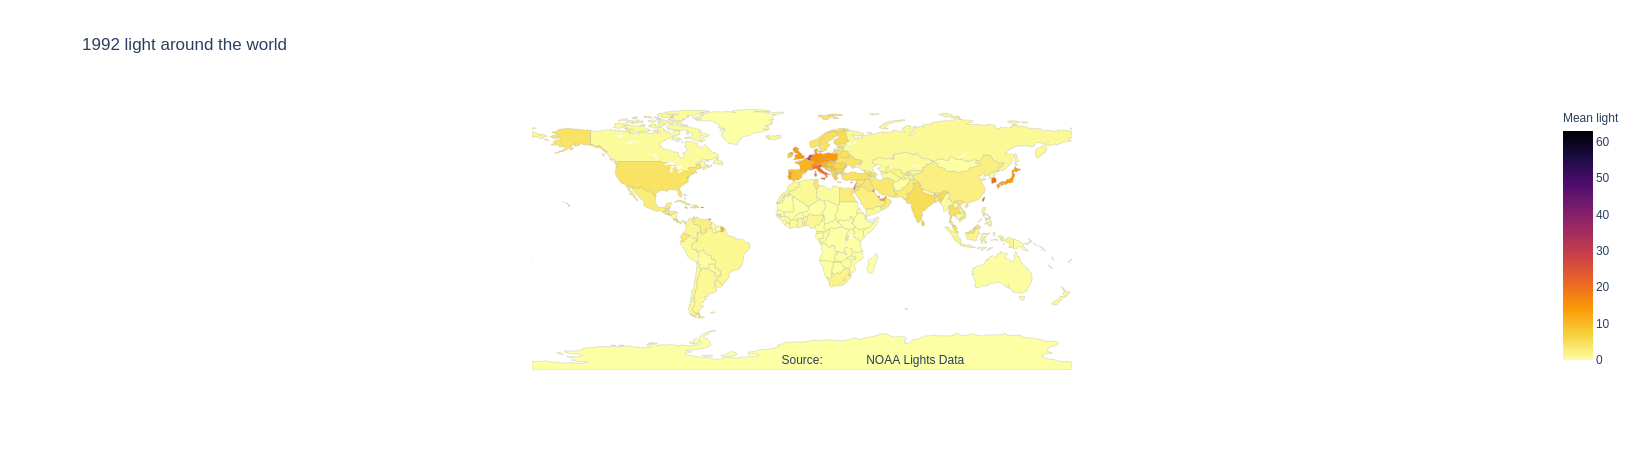

In [316]:
import plotly.graph_objects as go
df = df_lights_list[-1]
fig = go.Figure(data=go.Choropleth(
    locations = df['ISO_A3'],
    z = df['mean_light'],
    text = df['ADMIN'],
    colorscale = 'Inferno',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.3,
    colorbar_tickprefix = '',
    colorbar_title = 'Mean light',
))

fig.update_layout(
    title_text='1992 light around the world',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    annotations = [dict(
        x=0.55,
        y=0.0,
        xref='paper',
        yref='paper',
        text='Source: <a href="https://ngdc.noaa.gov/eog/download.html">\
            NOAA Lights Data </a>',
        showarrow = False
    )]
)

fig.show()


In [317]:
# creating empty objects to store results
df_lights_list = []
data_plot = []
button_list = []
# list to mark which dataset to show depending on button choice
false_list = [False] * len(np.unique(df_lights_pd['year']))

for i,year_i in enumerate(np.unique(df_lights_pd['year'])):
    
    df_temp = df_lights_pd[df_lights_pd['year'] == year_i].reset_index(drop = True)
    
    # take the most recent camera for the year if there are multiple images
    df_temp = df_temp[df_temp['cam'] == np.max(np.unique(df_temp['cam']))].reset_index(drop = True)
    
    df_lights_list.append(df_temp)
    
    # list of data objects for the plotly map
    data_plot.append( go.Choropleth(
                        locations = df_temp['ISO_A3'],
                        z = df_temp['mean_light'],
                        text = df_temp['ADMIN'],
                        colorscale = 'Inferno',
                        autocolorscale=False,
                        reversescale=True,
                        marker_line_color='darkgray',
                        marker_line_width=0.3,
                        colorbar_tickprefix = '',
                        colorbar_title = 'Mean light',
                        visible=False
                    )
               )
    
    # make the buttons in the dropdown menu
    button_list.append(dict(
                    args=['visible', [x if f_i != i else True for f_i, x in enumerate(false_list)]],
                    label=f'Year: {year_i}, cam: {df_temp.loc[0,"cam"]}',
                    method='restyle'
                ))

# mark the first year as true so there is data when running the notebook
data_plot[0]['visible'] = True


# used this site for help on syntax
# https://plotly.com/~empet/15237/choroplethmapbox-with-dropdown-menu/#/

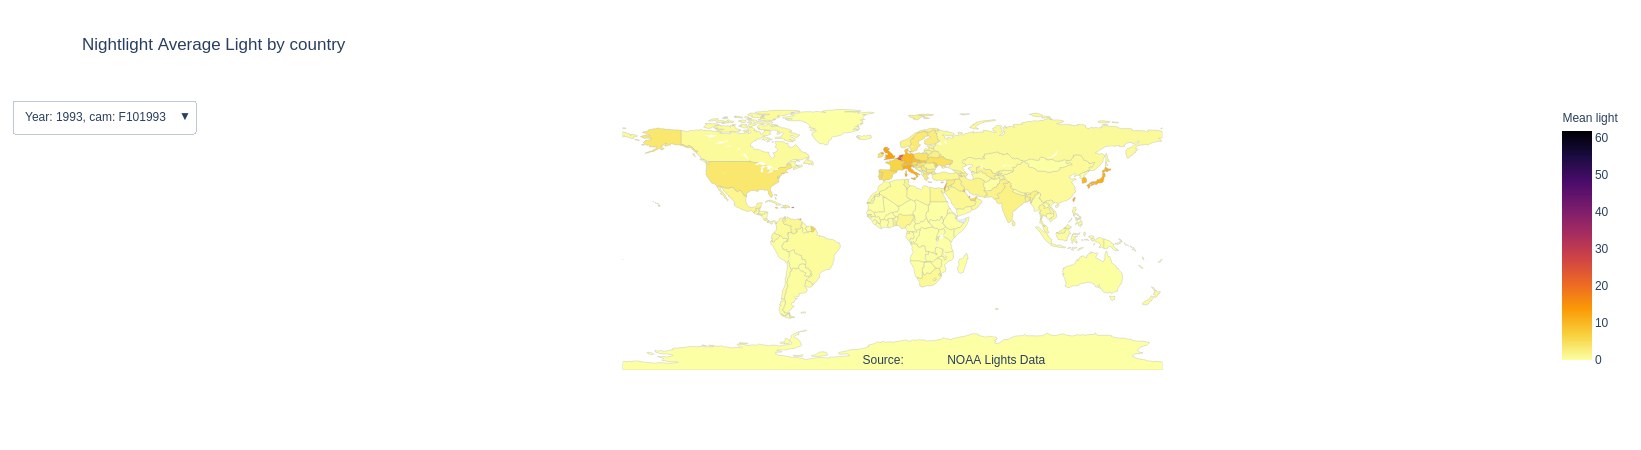

In [318]:
import plotly.graph_objects as go

layout = go.Layout(
    title_text='Nightlight Average Light by country',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    annotations = [dict(
        x=0.55,
        y=0.0,
        xref='paper',
        yref='paper',
        text='Source: <a href="https://ngdc.noaa.gov/eog/download.html">\
            NOAA Lights Data </a>',
        showarrow = False
    )]
)
layout.update(updatemenus=list([
        dict(
            x=-0.05,
            y=1,
            yanchor='top',
            buttons=list(button_list),
        )]))
fig=go.Figure(data=data_plot, layout =layout)
fig.show()


### Get the largest changes in light from beginning to end of period

In [319]:
country_list = np.unique(df_lights_pd['ISO_A3'])
print(f'{len(country_list)} countries in the full dataset')

238 countries in the full dataset


In [320]:
df_lights_analysis = pd.concat(df_lights_list)

In [321]:
df_lights_analysis

,ADMIN,ISO_A3,cam,mean_light,year
0,Aruba,ABW,F101993,30.7313,1993
1,Afghanistan,AFG,F101993,0.0279431,1993
2,Angola,AGO,F101993,0.038532,1993
3,Anguilla,AIA,F101993,9.65,1993
4,Albania,ALB,F101993,0.264269,1993
...,...,...,...,...,...
245,Samoa,WSM,F182013,0.814183,2013
246,Yemen,YEM,F182013,0.895347,2013
247,South Africa,ZAF,F182013,1.84181,2013
248,Zambia,ZMB,F182013,0.182403,2013


In [322]:
df_lights_analysis = df_lights_analysis[df_lights_analysis['mean_light'] != 0]
df_sorted = df_lights_analysis.sort_values(['ADMIN','year']).reset_index(drop = True)
df_sorted['mean_light'] = df_sorted['mean_light'].astype('float')
df_differences = df_sorted.groupby('ADMIN').diff()
df_pct = df_sorted.groupby('ADMIN')['mean_light'].pct_change()

In [323]:
# create time series index for each country
def index_create(g):
    g['mean_light_index'] = np.nan
    start_i = g.head(1).index[0]
    for i, row_i in g.iterrows():
        if i == start_i:
            g.loc[i,'mean_light_index'] = 100
        else:
            g.loc[i,'mean_light_index'] = 100 * (g.loc[i,'mean_light'] / g.loc[start_i,'mean_light'])
        #print(f'''iteration: {i}, val: {g.loc[i,'mean_light_index']}''')
    return g
df_index = df_sorted.groupby("ADMIN").apply(index_create)

In [324]:
df_sorted['mean_light_diff'] = df_differences['mean_light']
df_sorted['mean_light_pct_diff'] = df_pct
df_sorted['mean_light_index'] = df_index['mean_light_index']

In [ ]:
# creating empty objects to store results
data_plot = []
button_list = []
# list to mark which dataset to show depending on button choice
false_list = [False] * len(np.unique(df_sorted['year']))

for i,year_i in enumerate(np.unique(df_sorted['year'])):
    
    df_temp = df_sorted[df_sorted['year'] == year_i].reset_index(drop = True)
    
    # take the most recent camera for the year if there are multiple images
    df_temp = df_temp[df_temp['cam'] == np.max(np.unique(df_temp['cam']))].reset_index(drop = True)
    
    # list of data objects for the plotly map
    data_plot.append( go.Choropleth(
                        locations = df_temp['ISO_A3'],
                        z = df_temp['mean_light_index'],
                        text = df_temp['ADMIN'],
                        colorscale = 'Inferno',
                        autocolorscale=False,
                        reversescale=True,
                        marker_line_color='darkgray',
                        marker_line_width=0.3,
                        colorbar_tickprefix = '',
                        colorbar_title = 'Mean light',
                        visible=False
                    )
               )
    
    # make the buttons in the dropdown menu
    button_list.append(dict(
                    args=['visible', [x if f_i != i else True for f_i, x in enumerate(false_list)]],
                    label=f'Year: {year_i}, cam: {df_temp.loc[0,"cam"]}',
                    method='restyle'
                ))

# mark the first year as true so there is data when running the notebook
data_plot[0]['visible'] = True


# used this site for help on syntax
# https://plotly.com/~empet/15237/choroplethmapbox-with-dropdown-menu/#/

layout = go.Layout(
    title_text='Nightlight Average Light Changes by Country',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    annotations = [dict(
        x=0.55,
        y=0.0,
        xref='paper',
        yref='paper',
        text='Source: <a href="https://ngdc.noaa.gov/eog/download.html">\
            NOAA Lights Data </a>',
        showarrow = False
    )]
)
layout.update(updatemenus=list([
        dict(
            x=-0.05,
            y=1,
            yanchor='top',
            buttons=list(button_list),
        )]))
fig=go.Figure(data=data_plot, layout =layout)
fig.show()


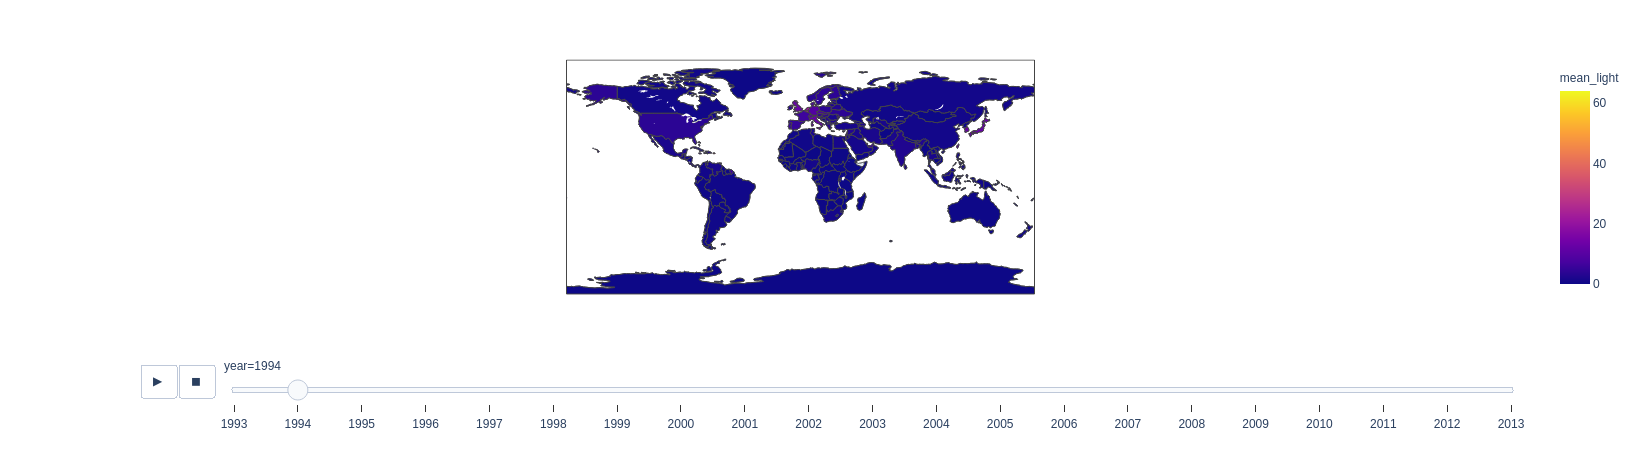

In [335]:
fig = px.choropleth(df_sorted, locations="ISO_A3", color="mean_light", hover_name="ADMIN", animation_frame="year", range_color=[0,64])
fig.show()

Most of the variety in the colors are a result of just a few countries. Let's see what the distribution looks like more closely.

In [327]:
df_sorted.describe()

,mean_light,year,mean_light_diff,mean_light_pct_diff,mean_light_index
count,5146.000000,5146.000000,4900.000000,4900.000000,5146.000000
mean,7.041947,2003.010688,0.146780,0.166078,215.891255
std,11.817260,6.047920,1.779077,1.891174,379.988198
min,0.000299,1993.000000,-16.000000,-0.984671,2.298851
25%,0.309050,1998.000000,-0.101082,-0.088535,109.255636
50%,1.838703,2003.000000,0.014151,0.042316,147.145922
75%,8.076430,2008.000000,0.373000,0.194999,210.827393
max,62.947899,2013.000000,15.400000,91.058824,10433.333333


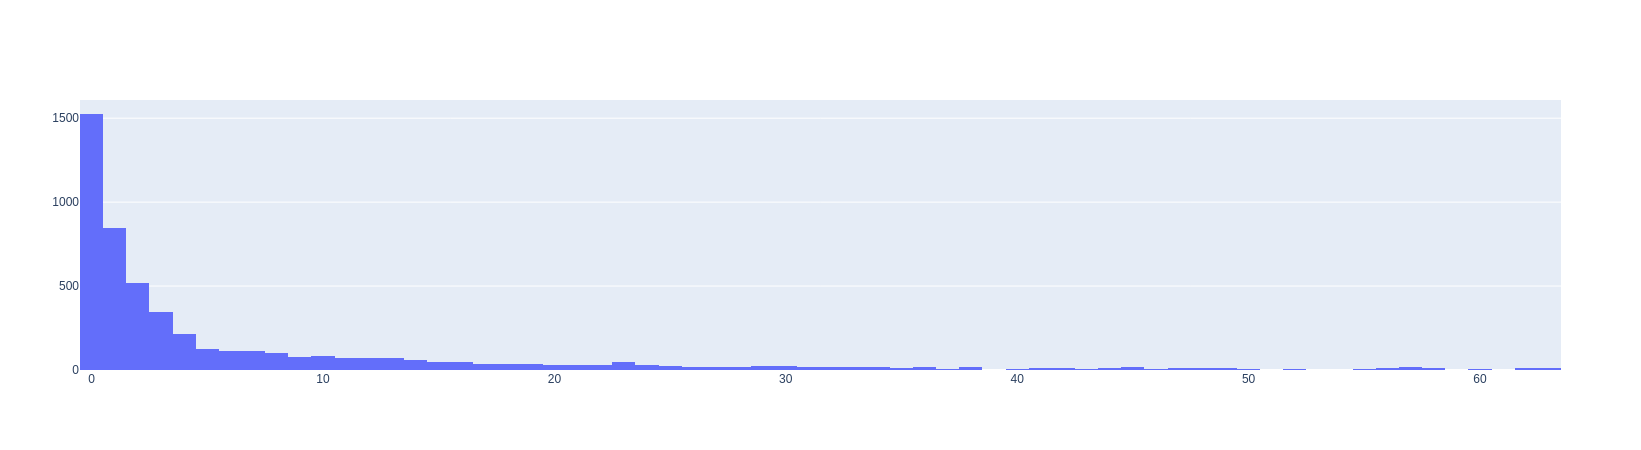

In [330]:
fig = go.Figure(data=[go.Histogram(x=df_sorted['mean_light'])])

fig.show()

Since most of the distribution is below 10. We're going to view the map with 10 as the max and not see differences past that point.

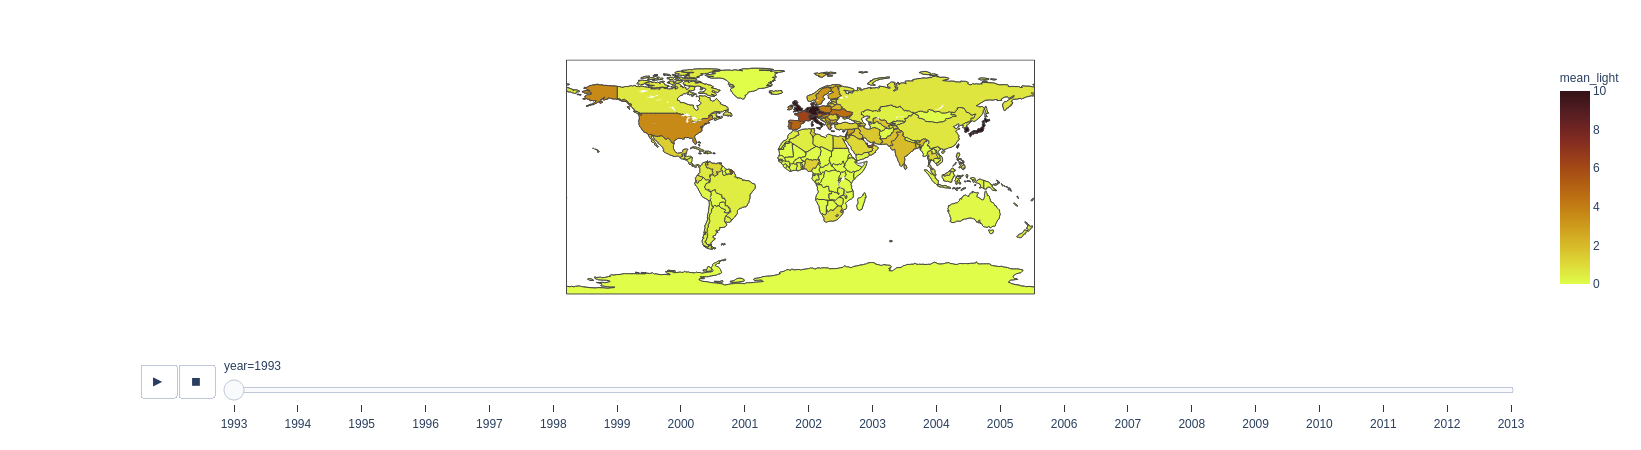

In [339]:
fig = px.choropleth(df_sorted, locations="ISO_A3", color="mean_light", hover_name="ADMIN", animation_frame="year", range_color=[0,10], color_continuous_scale=px.colors.sequential.solar_r)
fig.show()

In [340]:
dev_countries= ['India','China','North Korea',
                 'Bangladesh','Thailand',
                 'Philippines','Indonesia','Russia',
                'Brazil','South Africa','Vietnam','Malaysia','Laos'
               ]

df_dev_countries = df_sorted[df_sorted['ADMIN'].isin(dev_countries)]

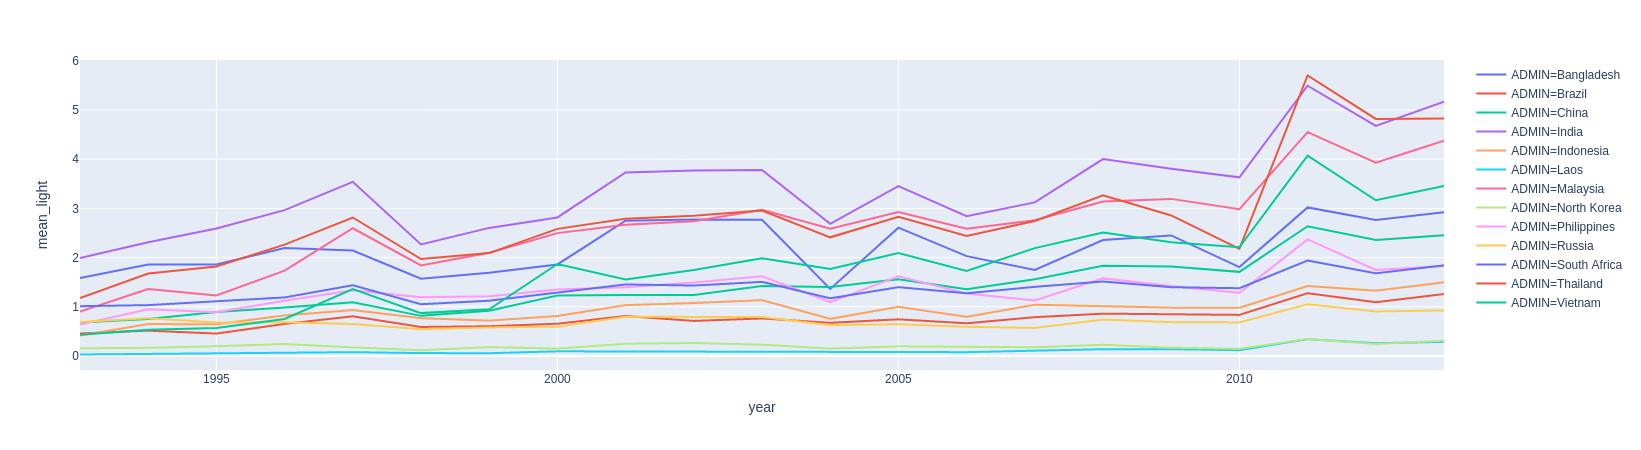

In [343]:
fig = px.line(df_dev_countries, x = 'year', y = 'mean_light', 
              color = 'ADMIN', line_group = 'ADMIN', hover_name = 'ADMIN')
fig.show()

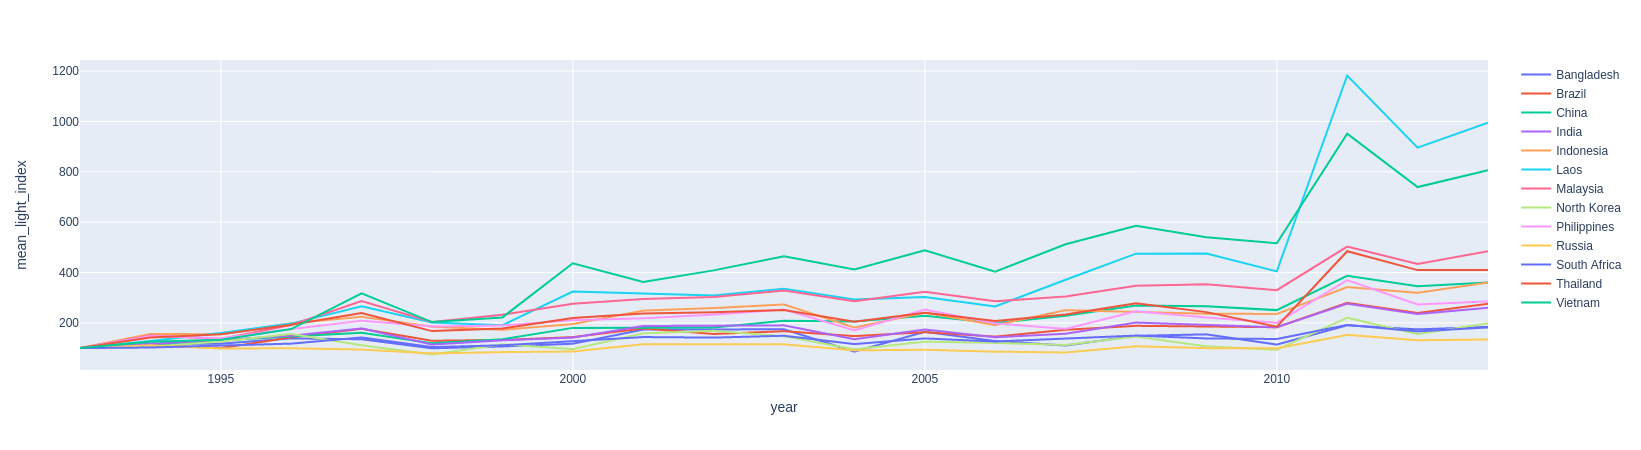

In [344]:
fig = px.line(df_dev_countries, x = 'year', y = 'mean_light_index', 
              color = 'ADMIN')
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))
fig.for_each_trace(lambda t: t.update(name=t.name.split("=")[1]))
fig.show()

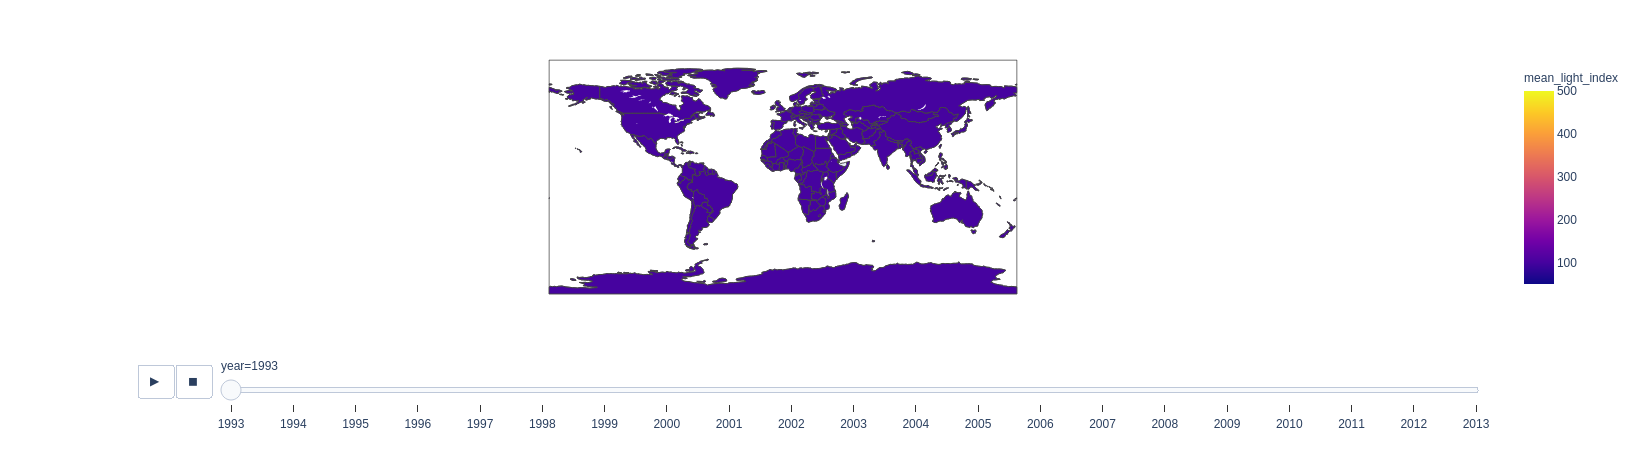

In [345]:
fig = px.choropleth(df_sorted, locations="ISO_A3", color="mean_light_index", hover_name="ADMIN", animation_frame="year", range_color=[50,500])
fig.show()

In [286]:
pickle.dump(df_sorted, open('lights_data_prep.pkl','wb'))